#**Coding session2 -Working with whole slide images**

# What shall we cover?
  * Load and display whole slide images using Openslide
  * Extract a patch from a slide
  * Retrieve data from whole slide image header
  * Load image annotations and display image labels superposed on image
  * Perform stain separation and color normalization
  * Practice session: 
      * Read in a WSI
      * Print high level header
      * Print low level header
      * Select a certain region within it and display

# Dataset used: 

PANDA- Prostate cancer diagnosis using the Gleason grading system

Microscopy scans (Whole slide) of prostate biopsy samples in .tiff format. 

Open dataset, 11.000 whole-slide images (WSI) of prostate biopsies from Radboud University Medical Center and the Karolinska Institute.

# Install open-slide

OpenSlide Python is a Python interface to the OpenSlide library.

OpenSlide is a C library that provides a simple interface for reading whole-slide images, also known as virtual slides, which are high-resolution images used in digital pathology.

In [ ]:
!apt update && apt install -y openslide-tools

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,492 kB]
Get:1

In [ ]:
!pip install openslide-python

     |████████████████████████████████| 316 kB 4.1 MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27714 sha256=307bf8b4beaab5601c4045302519d216a57b2fa07225c421cbf96ea78cb38de2
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python


# Import necessary libraries

In [ ]:
import openslide
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Load Google drive containing images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Specify path to Whole slide image and annotation

In [ ]:
data_path = '/content/drive/My Drive/colab_notebooks/lp_covid/beta_tested_notebooks/ws1.tiff'
mask_path = '/content/drive/My Drive/colab_notebooks/lp_covid/beta_tested_notebooks/ws1_mask.tiff'

# Load whole slide from data path

In [ ]:
image = openslide.OpenSlide(data_path)

# Like Dicom images, whole slide images also contain metadata which can be read.

In [ ]:
from openslide import OpenSlide, lowlevel 

slide1 = lowlevel.open(data_path)
keys1 = lowlevel.get_property_names(slide1)

print(keys1)


['openslide.level-count', 'openslide.level[0].downsample', 'openslide.level[0].height', 'openslide.level[0].tile-height', 'openslide.level[0].tile-width', 'openslide.level[0].width', 'openslide.level[1].downsample', 'openslide.level[1].height', 'openslide.level[1].tile-height', 'openslide.level[1].tile-width', 'openslide.level[1].width', 'openslide.level[2].downsample', 'openslide.level[2].height', 'openslide.level[2].tile-height', 'openslide.level[2].tile-width', 'openslide.level[2].width', 'openslide.quickhash-1', 'openslide.vendor', 'tiff.ResolutionUnit', 'tiff.XResolution', 'tiff.YResolution']


In [ ]:
xres= int(lowlevel.get_property_value(slide1, 'tiff.XResolution')) 
yres = int(lowlevel.get_property_value(slide1, 'tiff.YResolution')) 
unit = lowlevel.get_property_value(slide1, 'tiff.ResolutionUnit')
vendor = lowlevel.get_property_value(slide1, 'openslide.vendor')

print(xres, yres, unit, vendor)

22123 22123 centimeter generic-tiff


In [ ]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600,400)):
    """Print some basic information about a slide"""
    # Generate a small image thumbnail
    if show_thumbnail:
        display(slide.get_thumbnail(size=max_size))

    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")


# Print slide metadata

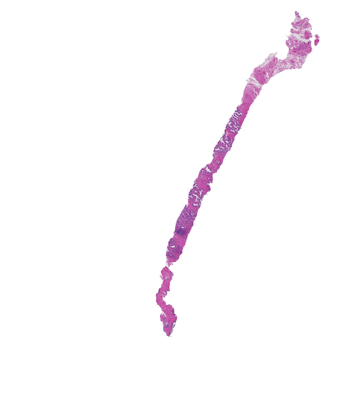

File id: OpenSlide('/content/drive/My Drive/colab_notebooks/lp_covid/beta_tested_notebooks/ws1.tiff')
Dimensions: (31744, 37632)
Microns per pixel / pixel spacing: 0.452
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((31744, 37632), (7936, 9408), (1984, 2352))


In [ ]:
fullslide = openslide.OpenSlide(data_path)
print_slide_details(fullslide)

# Using the read_region function of Openslide
With OpenSlide one can extract patches from the slide from arbitrary locations. Loading a specific region is done using the read_region function.

region = read_region((x,y), level, (width, height))

Function: 
Arguments : ((x, y), level, (wsi_image-width, wsi_image-height)

(x,y) are the coordinates of top left corner of patch

Show region at level 0


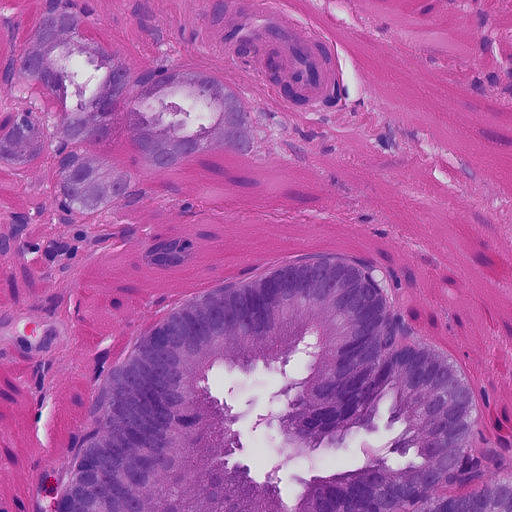

In [ ]:
x = 17800
y = 19500
level = 0
width = 512
height = 512

region = fullslide.read_region((x,y), level, (width, height))
display(region)

# Show patch region at level 1

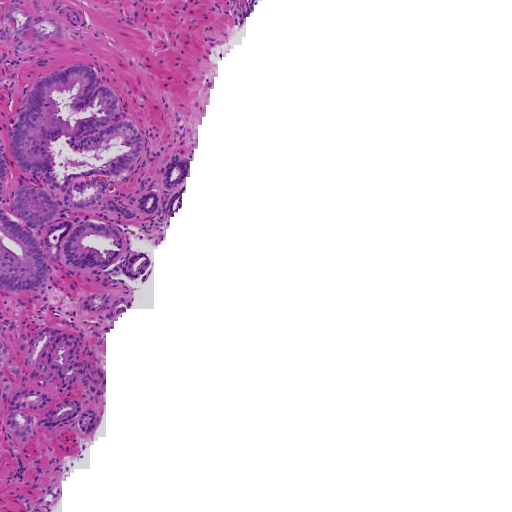

In [ ]:
x = 17800
y = 19500
level = 1
width = 512
height = 512

region = fullslide.read_region((x,y), level, (width, height))
display(region)

#Note 1 : Using the level argument we can easily load in data from any level that is present in the slide. 

#Note 2 :  Coordinates passed to read_region are always relative to level 0 (the highest resolution).

Read annotated regions from annotated image

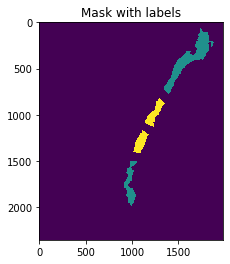

In [ ]:
mask = openslide.OpenSlide(mask_path)
mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

plt.figure()
plt.title("Mask with labels")
plt.imshow(np.asarray(mask_data)[:,:,0], interpolation='nearest')
plt.show()

# Filter mask regions according to annotations

0: background (non tissue) or unknown

1: benign tissue (stroma and epithelium combined)

2: cancerous tissue (stroma and epithelium combined)

In [ ]:

mask_level = mask.read_region((0,0),mask.level_count - 1,mask.level_dimensions[-1]) #Selecting the level
mask_data = np.asarray(mask_level)[:,:,0] #SELECTING R from RGB
    
mask_background = np.where(mask_data == 0, 1, 0).astype(np.uint8) # SELECTING BG
mask_benign = np.where(mask_data == 1, 1, 0).astype(np.uint8) #SELECTING BENIGN LABELS

mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS
    

# Benign regions

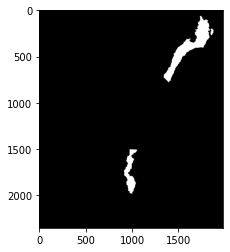

In [ ]:
plt.imshow(mask_benign.astype(float), cmap=plt.cm.gray)

# Cancerous

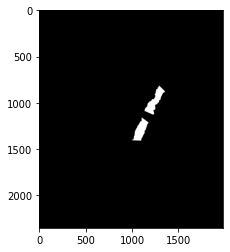

In [ ]:
plt.imshow(mask_cancerous.astype(float), cmap=plt.cm.gray)

# A function to overlay annotated region on slide

In [ ]:
def overlay_mask_on_slide(slide, mask, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Load data from the highest level
    slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

    # Mask data is present in the R channel
    mask_data = mask_data.split()[0]

    # Create alpha mask
    alpha_int = int(round(255*alpha))
    if center == 'radboud':
        alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
    elif center == 'karolinska':
        alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)
    
    alpha_content = PIL.Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)
    
    if center == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
    
    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')

    overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    overlayed_image.thumbnail(size=max_size, resample=0)

    display(overlayed_image)

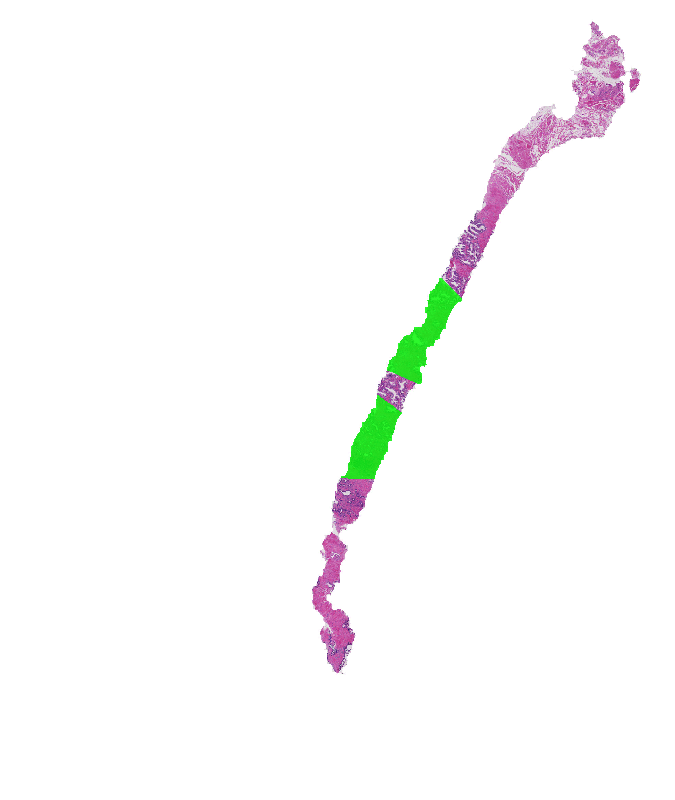

In [ ]:
overlay_mask_on_slide(fullslide, mask, center='radboud')

# Stain separation, color deconvolution : RGB to HED

The scikit-image skimage.color package features an rgb2hed() function that performs color deconvolution on the original RGB image to create HED (Hematoxylin, Eosin, Diaminobenzidine) channels. The filter_rgb_to_hed() function encapsulates rgb2hed(). The filter_hed_to_hematoxylin() and filter_hed_to_eosin() functions read the hematoxylin and eosin channels and rescale the resulting 2-dimensional NumPy arrays (for example, 0 to 255 for uint8) to increase contrast

#Load libraries

In [ ]:
import numpy as np

from skimage import data
from skimage.color import rgb2hed, hed2rgb

# Select patch region

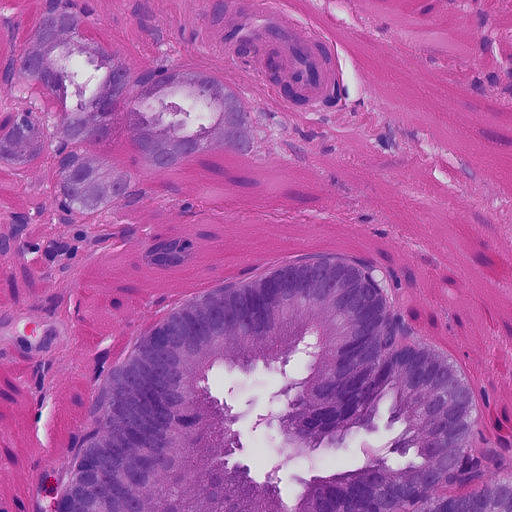

In [ ]:
x = 17800
y = 19500
level = 0
width = 512
height = 512

region = fullslide.read_region((x,y), level, (width, height))

display(region)

# Convert to RGB

In [ ]:
rgb_image = region.convert('RGB')

In [ ]:
ihc_hed = rgb2hed(rgb_image)
ihc_hed[ihc_hed<0] = 0  # TODO: remove this after fixing `rgb2hed()`

null = np.zeros_like(ihc_hed[:,:,0])
ihc_h = hed2rgb(np.stack((ihc_hed[:,:,0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:,:,1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:,:,2]), axis=-1))

# Display stain separated images

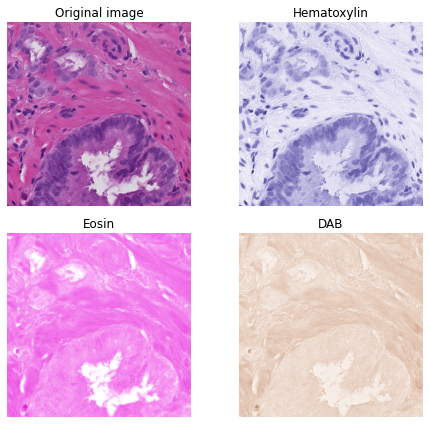

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_image)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()

# Stain Normalization

The first step in analyzing digital pathology images is preprocessing the color image to correct staining or imaging variations. 

In [ ]:
import numpy as np
img = np.array(rgb_image)
Io= 240
beta = 0.15
alpha = 1.0
HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
maxCRef = np.array([1.9705, 1.0308])
    
# define height and width of image
h, w, c = img.shape
    
    # reshape image
img = img.reshape((-1,3))

    # calculate optical density
OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3])
    
phi = np.arctan2(That[:,1],That[:,0])
    
minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)
    
vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
if vMin[0] > vMax[0]:
  HE = np.array((vMin[:,0], vMax[:,0])).T
else:
  HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  


# Display original and normalized image side by side

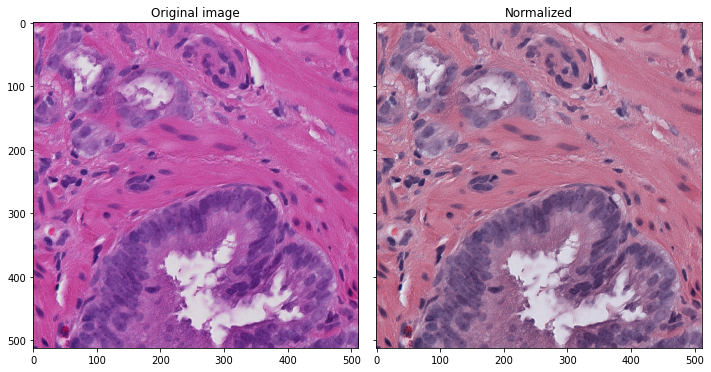

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_image)
ax[0].set_title("Original image")

ax[1].imshow(Inorm)
ax[1].set_title("Normalized")


fig.tight_layout()
plt.show()

# Practice session:

* Read in a WSI
* Print high level header
* Print low level header
* Select a certain region within it and display


In [ ]:
data_path2 = '/content/drive/My Drive/colab_notebooks/lp_covid/beta_tested_notebooks/ws2.tiff'

In [ ]:
image2 = openslide.OpenSlide(data_path2)

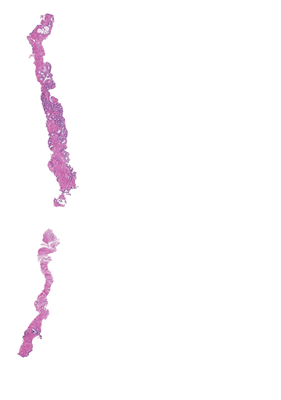

File id: OpenSlide('/content/drive/My Drive/colab_notebooks/lp_covid/beta_tested_notebooks/ws2.tiff')
Dimensions: (19919, 28342)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000442408574729, 16.00772289712245)
Dimensions of levels: ((19919, 28342), (4979, 7085), (1244, 1771))


In [ ]:

print_slide_details(image2)

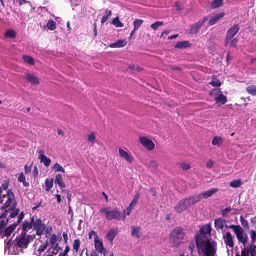

In [ ]:
patch2 = image2.read_region((1500, 25000), 0, (256, 256))
display(patch2)


In [ ]:
pwd

'/content'